# Neural Networks gone wild! They can sample from discrete distributions now!
![Photo by Jonathan Petersson on Unsplash](images/gumbel-gan/cover.jpg)

Training deep neural networks usually boils down to defining your model's architecture and a loss function, and watching the gradients propagate.

However, sometimes it's not that simple: some architectures incorporate a random component. The forward pass is no longer a deterministic function of the input and weights. The random component introduces stochasticity, by means of sampling from it.

When would that happen, you ask? Whenever we want to approximate an intractable sum or integral. Then, we can form a Monte Carlo estimate. A good example is [the variational autoencoder](https://arxiv.org/abs/1312.6114). Basically, it's an autoencoder on steroids: the encoder's job is to learn a *distribution* over the latent space. The loss function contains an intractable expectation over that distribution, so we sample from it.

As with any architecture, the gradients need to propagate to the weights of the model. Some of the weights are responsible for transforming the input into the parameters of the distribution from which we sample. Here we face a problem: the gradients can't propagate through random nodes! Hence, these weights won't be updated.

One solution to the problem is the reparameterization trick: you substitute the sampled random variable with a deterministic parameterized transformation of a parameterless random variable.

If you don't know this trick I highly encourage you to [read about it](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/). I'll demonstrate it with the Gaussian case:

Let $Z \sim \mathcal{N}(\mu(X), \sigma^2(X))$. The parameters of the Gaussian are a function of the input $X$ - e.g. the output of stacked dense layers. When sampling realizations of $Z$, gradients won't be able to propagate to the weights of the dense layers. We can substitute $Z$ with a different random variable $Z' = \mu(X) + \sigma(X) \cdot \mathcal{E}$ where $\mathcal{E} \sim \mathcal{N}(0, 1)$. Now the sampling will be from $\mathcal{E}$, so the gradients won't propagate through this path - which we don't care about. However, through $\mu(X)$ and $\sigma(X)$ they will, since it's a deterministic path.

For many types of continuous distributions you can do the reparameterization trick. But what do you do if you need the distribution to be over a discrete set of values?

In the following sections you'll learn:
- what the Gumbel distribution is
- how it is used for sampling from a discrete distribution
- how the weights that affect the distribution's parameters can be trained
- how to use all of that in a toy example (with code)

# The Gumbel distribution
The Gumbel distribution has two parameters - $\mu$ and $\beta$. The standard Gumbel distribution, where $\mu$ and $\beta$ are 0 and 1 respectively, has PDF of $e^{-(x + e^{-x})}$.

Why should you care about this distribution? Consider the setting where you have a discrete random variable whose logits are $\{\alpha_i\}_{i=1}^k$. The logits are a function of the input and weights that need to be trained.

What I'm going to describe next is called the Gumbel-max trick. Using this trick, you can sample from the discrete distribution. The process is as follows:

1. Sample i.i.d samples $\{z_i\}_{i=1}^k$ from the standard Gumbel distribution.
2. Add the samples to the logits: $\{\alpha_i + z_i\}_{i=1}^k$.
3. Take the index of the maximal value: $\text{argmax}_{i=1}^k\alpha_i + z_i$.

The result will be a random sample of your original distribution. You can read the proof [here](https://hips.seas.harvard.edu/blog/2013/04/06/the-gumbel-max-trick-for-discrete-distributions/).

Great! So we were able to substitute our distribution with a deterministic transformation of a parameterless distribution! So if we plug it into our model, the gradients will be able to propagate to the weights of the logits, right?

Well, not so fast! Gradients can't propagate through argmax...

# Gumbel-softmax trick to the rescue!
![Photo by Radu Florin on Unsplash](images/gumbel-gan/gumbel-softmax.jpg)

Using argmax is equivalent to using one hot vector where the entry corresponding to the maximal value is 1.

So instead of using a hard one hot vector, we can approximate it using a soft one - softmax.

The process is the same as the process described above, except now you apply softmax instead of argmax.

And voila! Gradients can propagate to the weights of the logits.

There's one hyperparameter I didn't tell you about (yet) - the temperature:

$\frac{\text{exp}((\log(\alpha_i)+z_i) \cdot \tau^{-1})}{\sum_{j=1}^k \text{exp}((\log(\alpha_j)+z_j) \cdot \tau^{-1})}$

By dividing by a temperature $\tau > 0$, we can control how close the approximation will be to argmax. When $\tau \to 0$ the entry corresponding to the maximal value will tend to 1, and the other entries will tend to 0. When $\tau \to \infty$ the result will tend to uniform. The smaller $\tau$ is the better the approximation gets. The problem with setting $\tau$ to small values is that the variance of the gradients will be too high. This will make it difficult for the training. A good practice is to start with big temperature and then anneal it towards small values.

You can read more about the Gumbel-softmax trick [here](https://arxiv.org/abs/1611.01144) and [here](https://arxiv.org/abs/1611.00712).

# Enough theory - it's code time!
![Photo by Blake Connally on Unsplash](images/gumbel-gan/code.jpg)

To show that the theory works in real life, I'll use a toy problem. The data is a stream of numbers in the range 0 to 4. Each number has a different probability to come up in the stream. Your mission, should you choose to accept it, is to find out what the distribution over the 5 numbers is.

A simple solution would be to count, but we're going to do something much cooler (and ridiculously too complicated for this task): we'll train a [GAN](https://arxiv.org/abs/1406.2661). The generator will generate numbers from a distribution which should converge to the real one.

Here's an intuition of why it should work: let's say the true probability associated with the number 0 is 0. The discriminator will learn that 0's never come with the label REAL. Therefore, the generator will incur a big loss whenever it generates 0's. This will encourage the generator to stop generating 0's.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(42)
tf.set_random_seed(42)

%matplotlib inline

/Users/yoel.z/projects/kaggle/kaggle-env/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


These are all the hyperparameters we're going to use:

In [2]:
BATCHS_IN_EPOCH = 100
BATCH_SIZE = 10
EPOCHS = 200  # the stream is infinite so one epoch will be defined as BATCHS_IN_EPOCH * BATCH_SIZE
GENERATOR_TRAINING_FACTOR = 10  # for every training of the disctiminator we'll train the generator 10 times
LEARNING_RATE = 0.0007
TEMPERATURE = 0.001  # we use a constant, but for harder problems we should anneal it

We'll define the stream of data using `tf.data.Dataset.from_generator`. The underlying generator continuously samples numbers according to a predefined distribution:

In [3]:
number_to_prob = {
    0: 0.0,
    1: 0.0,
    2: 0.1,
    3: 0.3,
    4: 0.6
}


def generate_text():
    while True:
        yield np.random.choice(number_to_prob.keys(), p=number_to_prob.values(), size=1)


dataset = tf.data.Dataset.from_generator(generate_text,
                                         output_types=tf.int32,
                                         output_shapes=1).batch(BATCH_SIZE)
value = dataset.make_one_shot_iterator().get_next()
value = tf.one_hot(value, len(number_to_prob))
value = tf.squeeze(value, axis=1)

# The model architecture
![Photo by Dmitri Popov on Unsplash](images/gumbel-gan/architecture.jpg)

The core of the generator is the Gumbel distribution. Tensorflow already has an implementation for it - `RelaxedOneHotCategorical`. We'll follow the same process described above: sample from the standard Gumbel distribution, add the result to the logits, and apply softmax. The logits are what the generator has to learn.

In [4]:
def generator():
    with tf.variable_scope('generator'):
        logits = tf.get_variable('logits', initializer=tf.ones([len(number_to_prob)]))
        gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(TEMPERATURE, logits=logits)
        probs = tf.nn.softmax(logits)
        generated = gumbel_dist.sample(BATCH_SIZE)
        return generated, probs

The discriminator is a logistic regression model. Being simple, it allows us to focus in this demonstration on the  Gumbel-softmax trick. If the discriminator were any smarter, we would have faced some challenges, such as:
- choosing a good schedule for the temperature annealing.
- smoothing the real data from the stream, or otherwise the discriminator would be able to learn that smooth vectors mean FAKE, and hard vectors mean REAL.

In [5]:
def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        return tf.contrib.layers.fully_connected(x,
                                                 num_outputs=1,
                                                 activation_fn=None)

Next, we're going to define the usual GAN loss and training ops - one for the discriminator and one for the generator.

In [6]:
generated_outputs, generated_probs = generator()
discriminated_real = discriminator(value)
discriminated_generated = discriminator(generated_outputs)

d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminated_real,
                                            labels=tf.ones_like(discriminated_real)))
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminated_generated,
                                            labels=tf.zeros_like(discriminated_generated)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminated_generated,
                                            labels=tf.ones_like(discriminated_generated)))

all_vars = tf.trainable_variables()
g_vars = [var for var in all_vars if var.name.startswith('generator')]
d_vars = [var for var in all_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(LEARNING_RATE).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(LEARNING_RATE).minimize(g_loss, var_list=g_vars)

# Train, baby, train!
![Photo by Steven Lelham on Unsplash](images/gumbel-gan/training.jpg)

In [7]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    learned_probs = []
    for _ in range(EPOCHS):
        for _ in range(BATCHS_IN_EPOCH):
            sess.run(d_train_opt)
            for _ in range(GENERATOR_TRAINING_FACTOR):
                sess.run(g_train_opt)
        learned_probs.append(sess.run(generated_probs))

After each epoch we evaluate `generated_probs`. At the beginning it's random, and as training progresses it should (hopefully) converge towards the real distribution defined by `number_to_prob`.

To see if it happens, we can plot the difference between the two distributions:

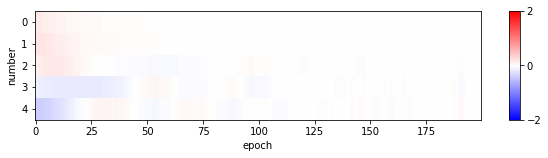

In [8]:
plt.figure(figsize=(10, 2))
prob_errors = [np.array(learned_prob) - np.array(number_to_prob.values())
               for learned_prob in learned_probs]
plt.imshow(np.transpose(prob_errors),
           cmap='bwr',
           aspect='auto',
           vmin=-2,
           vmax=2)
plt.xlabel('epoch')
plt.ylabel('number')
plt.colorbar(aspect=10, ticks=[-2, 0, 2]);

Red means the generator erroneously output too big probability, and blue means too small. White means it converged.

We can see that by the end of the training all the entries have pretty much converged. Sweet!

# Conclusion
In this post you learned what the Gumbel-softmax trick is.

Using this trick, you can sample from a discrete distribution and let the gradients propagate to the weights that affect the distribution's parameters.

This trick opens doors to many interesting applications. For start, you can find an example of text generation in the paper [GANS for Sequences of Discrete Elements with the Gumbel-softmax Distribution](https://arxiv.org/abs/1611.04051).

Feel free to drop a line in the comments if you find more interesting use cases!